![Screen%20Shot%202022-03-31%20at%203.36.37%20PM.png](attachment:Screen%20Shot%202022-03-31%20at%203.36.37%20PM.png)

## Background
Globally, 1 in 71 children contract pneumonia every year. Unfortunately, pediatric pneumonia is also frequently fatal resulting in an estimated 2,200 deaths per day worldwide. To diagnose pediatric pneumonia, highly skilled physicians such as pediatric radiologists are needed to interpret the medical imaging. However, the distribution of these providers is highly disparate globally.

## Business Problem
Countries with few pediatric radiologists per capita may have potentially higher risks of delays in diagnosis and corresponding treatment failures. Higher costs and interventional risks may also be worsened. Thus, our team endeavored to produce a diagnostic support tool, leveraging machine learning to speed and improve diagnosis of pediatric pneumonia. We believe our diagnostic support tool will be particularly useful in helping healthcare providers in countries with few pediatric radiologists per capita.

## Data Understanding
We used 5848 pediatric chest xrays to develop a diagnostic support tool that can differentiate between a normal chest xray (CXR) and a chest xray in a pediatric patient with pneumonia. There were 1575 normal CXR, 4273 pneumonia CXR. Recall was the metric of choice as failure to properly diagnose pneumonia (or false negative) could potentially be fatal to the child. Using recall allows us to try to reduce these false negatives.

## Modeling
We used a convolutional neural network (CNN) to developed our diagnostic support tool as they’re good for image classification. CNNs are particularly strong when for image classification especially wehn geared towards color images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/RH3421/Project-4.git

Cloning into 'Project-4'...
remote: Enumerating objects: 6126, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 6126 (delta 31), reused 13 (delta 5), pack-reused 6066
Receiving objects: 100% (6126/6126), 1.14 GiB | 21.50 MiB/s, done.
Resolving deltas: 100% (145/145), done.
Updating files: 100% (5870/5870), done.


In [3]:
cd data_split

[Errno 2] No such file or directory: 'data_split'
/content


In [4]:
%cd Project-4
!ls

/content/Project-4
data_split  Images  Main_Notebook.ipynb  Presentation.pdf  README.md


In [33]:
# Importing libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil

from tensorflow import keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [28]:
classes = ['normal', 'pneumonia']
test_classes = ['NORMAL', 'PNEUMONIA']

# Instantiate ImageDataGenerator and normalize the RGB values
traingen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.12)
testgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)


# Creating training data generator
train_data = traingen.flow_from_directory(
    # Specifying location of training data
    directory='data_split/train',
    # Re-sizing images to 200x200
    target_size=(200, 200),
    classes = classes,
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=64,
    subset = 'training',
    seed=16
)

# Creating a validation data generator
val_data = traingen.flow_from_directory(
        directory = 'data_split/train',
        target_size=(200, 200),
        batch_size=64,
        classes = classes,
        class_mode='binary',
        subset='validation',
        seed=16
)

# Creating testing data generator
test_data = testgen.flow_from_directory(
    # Specifying location of testing data
    directory='data_split/test',
    # Re-sizing images to 200x200
    target_size=(200, 200),
    classes = test_classes,
    # Class mode to binary to recoginize the two directories "Normal" and "PNA" as the labels
    class_mode='binary',
    batch_size=64,
    seed=16
)

Found 4599 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Create classification for images.

In [7]:
# Create a DataFrame to store the classes and their counts
classes_df = pd.DataFrame(train_data.classes)
values = classes_df.value_counts()
values

1    3418
0    1181
dtype: int64

In [8]:
# Define the mapping dictionary for class labels
class_dict = {0:'Normal', 1:'PNA'}

# Map class labels to binary labels in the DataFrame
classes_df[0] = classes_df[0].map(class_dict)

In [9]:
# Count the number of images per class based on binary labels
image_interpretation = classes_df[0].value_counts()
image_interpretation

PNA       3418
Normal    1181
Name: 0, dtype: int64

In [10]:
# Calculate the percentage of PNA vs. normal chest X-rays
classes_df[0].value_counts(normalize=True)

PNA       0.743205
Normal    0.256795
Name: 0, dtype: float64

Now that we have our train data and classification, let's visualize the images for preliminary inspection.

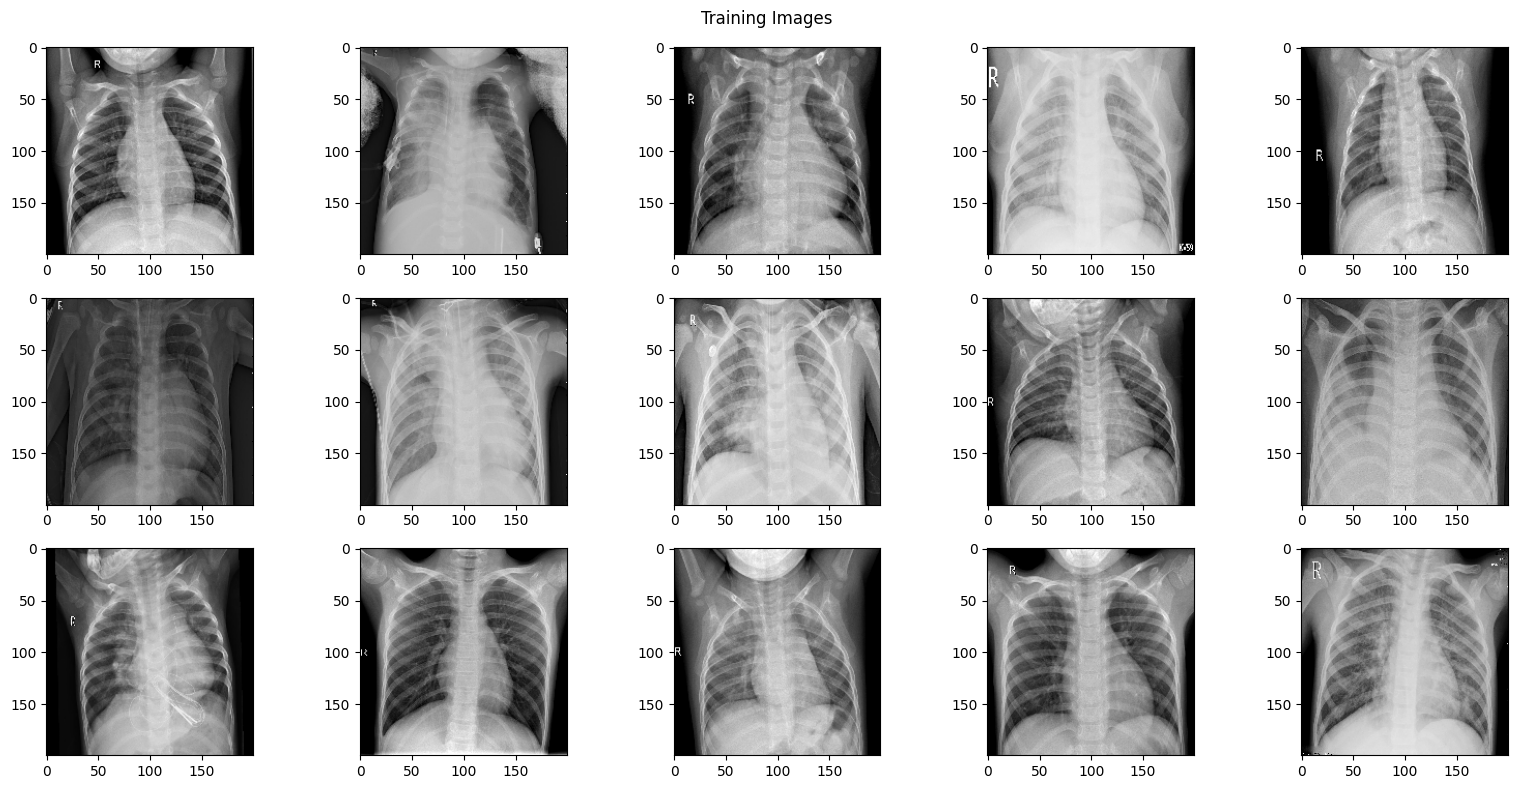

In [11]:
# Visualize
train_batch = train_data.next()
fig, axes = plt.subplots(3, 5, figsize=(16, 8))

for i in range(15):
    # Load image into numpy array, re-scale, and select the current subplot in the grid
    img = np.array(train_batch[0][i] * 255, dtype='uint8')
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
fig.suptitle('Training Images')
plt.tight_layout()
plt.show()

### Baseline Model
Essentially a logistic regression model with a single node output layer using a sigmoid activation function and 1 epoch.

In [12]:
# Building baseline logistic regression model
model_0 = keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 1)                 120001    
                                                                 
Total params: 120001 (468.75 KB)
Trainable params: 120001 (468.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile model
model_0.compile(loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [14]:
# Fit model
model_0.fit(train_data, epochs=1, batch_size=64, validation_data=(val_data))

72/72 [==============================] - 64s 879ms/step - loss: 8.8716 - recall: 0.7911 - val_loss: 10.2022 - val_recall: 1.0000


### Model 1
Added an 8 node hidden layer, continuing sigmoid activation function, rmsprop optimizer, and 3 epochs.

In [15]:
# Building first model
model_1 = keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Dense(8, activation="sigmoid"),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 200, 200, 8)       32        
                                                                 
 flatten_1 (Flatten)         (None, 320000)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 320001    
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Compile model
model_1.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [17]:
# Fit model
model_1.fit(train_data, epochs=3, batch_size=64, validation_data=(val_data))

Epoch 1/3
72/72 [==============================] - 85s 1s/step - loss: 35.8751 - recall_1: 0.7247 - val_loss: 36.7891 - val_recall_1: 1.0000
Epoch 2/3
72/72 [==============================] - 75s 1s/step - loss: 28.8321 - recall_1: 0.7303 - val_loss: 45.1261 - val_recall_1: 1.0000
Epoch 3/3
72/72 [==============================] - 79s 1s/step - loss: 27.5115 - recall_1: 0.7349 - val_loss: 4.6381 - val_recall_1: 1.0000


### Model 2
Added convolutional layers each followed by pooling layers for downsampling, switched to relu activation, added Adam optimizer, and 5 epoch run for improved model performance.

1st layer: hidden Conv2D layer, relu activation function<br/>
2nd layer: hidden Conv2D layer, relu activation function<br/>
3rd layer: 64 node hidden Dense layer, relu activation function<br/>
4th layer: Single node Dense layer, sigmoid activation function<br/>
Adam optimizer and 5 epochs

In [18]:
# CNN model with 2 convolutional layers
model_2 =  keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Conv2D(32, (3,3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 141376)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [19]:
# Compile model
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=.003),
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [20]:
# Fit model
training_sample = train_data.n
model_2.fit(train_data, epochs=5, batch_size=64,
            steps_per_epoch=int((training_sample//64)-1),
            validation_data=val_data)

Epoch 1/5
70/70 [==============================] - 561s 8s/step - loss: 0.5833 - recall_2: 0.8792 - val_loss: 0.3239 - val_recall_2: 0.9656
Epoch 2/5
70/70 [==============================] - 558s 8s/step - loss: 0.1809 - recall_2: 0.9602 - val_loss: 0.1934 - val_recall_2: 0.9140
Epoch 3/5
70/70 [==============================] - 562s 8s/step - loss: 0.0968 - recall_2: 0.9756 - val_loss: 0.1318 - val_recall_2: 0.9570
Epoch 4/5
70/70 [==============================] - 558s 8s/step - loss: 0.0828 - recall_2: 0.9795 - val_loss: 0.1806 - val_recall_2: 0.9140
Epoch 5/5
70/70 [==============================] - 545s 8s/step - loss: 0.1133 - recall_2: 0.9714 - val_loss: 0.2799 - val_recall_2: 0.8710


Model_2 appears to be overfitting slightly given the 96% recall on the training data and the 90% recall on the validation data. Let's see what adding an additional layer will do.

### Model 3
Added a third convolutional layer, bumping up to 10 epoch run for improved model performance.

1st layer: hidden Conv2D layer, relu activation function<br/>
2nd layer: hidden Conv2D layer, relu activation function<br/>
3rd layer: hidden Conv2D layer, relu activation function<br/>
4th layer: 64 node hidden Dense layer, relu activation function<br/>
5th layer: Single node Dense layer, sigmoid activation function<br/>
Adam optimizer and 10 epochs

In [40]:
# CNN model with 3 convolutional layers
model_3 = keras.Sequential(
    [   keras.Input(shape=(200,200,3)),
        keras.layers.Conv2D(64, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (5,5), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(16, (3,3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ])
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 196, 196, 64)      4864      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        51232     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 22, 22, 16)       

In [41]:
# Compile model
model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=.003),
                loss='binary_crossentropy',
              metrics=keras.metrics.Recall())

In [42]:
# Fit model
model_3.fit(train_data, epochs=10, batch_size=64,
                        steps_per_epoch=int((training_sample//64)-1),
                        validation_data=(val_data))

Epoch 1/10
70/70 [==============================] - 768s 11s/step - loss: 0.5310 - recall_4: 0.9545 - val_loss: 0.1993 - val_recall_4: 0.9871
Epoch 2/10
70/70 [==============================] - 764s 11s/step - loss: 0.1859 - recall_4: 0.9591 - val_loss: 0.1919 - val_recall_4: 0.9871
Epoch 3/10
70/70 [==============================] - 782s 11s/step - loss: 0.1262 - recall_4: 0.9726 - val_loss: 0.1932 - val_recall_4: 0.9140
Epoch 4/10
70/70 [==============================] - 808s 12s/step - loss: 0.1260 - recall_4: 0.9679 - val_loss: 0.2908 - val_recall_4: 0.9957
Epoch 5/10
70/70 [==============================] - 810s 12s/step - loss: 0.1436 - recall_4: 0.9711 - val_loss: 2.6119 - val_recall_4: 0.1269
Epoch 6/10
70/70 [==============================] - 814s 12s/step - loss: 0.4040 - recall_4: 0.9078 - val_loss: 0.2189 - val_recall_4: 0.9505
Epoch 7/10
70/70 [==============================] - 758s 11s/step - loss: 0.2274 - recall_4: 0.9545 - val_loss: 0.1742 - val_recall_4: 0.9570
Epoch 

Model_3 appears to have less overfitting than Model_2. Let's use this as the final model and evaluate performance on the test data.

In [43]:
# Evaluate final model on the holdout test data
model_3.evaluate(test_data)

10/10 [==============================] - 30s 3s/step - loss: 0.7819 - recall_4: 0.9769


[0.7818763256072998, 0.9769230484962463]

Nearly 98% recall on the test data. This means, as a diagnostic support tool Model_3 only fails to identify pediatric pneumonia in just over 1 out of every 50 xrays it processes!<br/>

## Conclusions
Utilization of a diagnostic support tool to accelerate identification of pediatric pneumonia without adding strain to hospital staff is of enormous value. This diagnostic support tool identifies pediatric pneumonia with high performance. This diagnostic support tool could be particularly valuable in underserved communities around the world where pediatric radiologists are scarce.

## Future Considerations
With additional resources and data this diagnostic support tool can be further improved and may be applicable for evaluation of adult chest xrays. Additionally, incorporation of clinical data, such as vitals signs and blood lab tests, should further improve the performance of this diagnostic support tool.